# Reimplementation of a model from "Large-Scale Item Categorization in e-Commerce Using Multiple Recurrent Neural Networks"

paper: https://www.kdd.org/kdd2016/papers/files/adf0392-haAemb.pdf

__Unfortunately, NAVER Shopping dataset is not publicly available.__ The data in the above paper had 
six features and were labeled with a specific leaf category - "large-scale real-world data including more than 94 million items with approximately 4,100 leaf categories from a Korean e-commerce website"

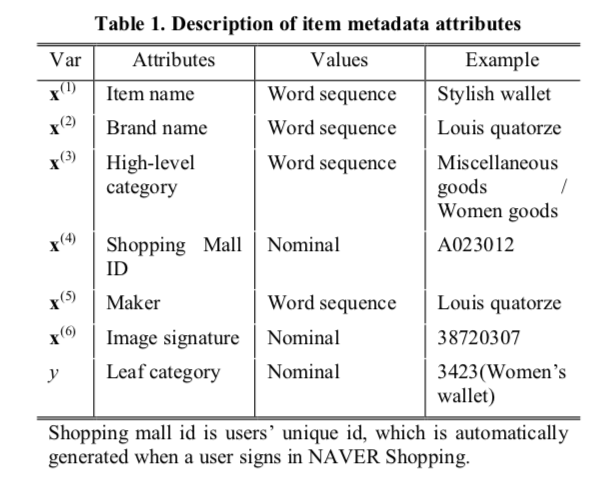

In [1]:
from IPython.display import Image
Image("/Users/tpalczew/Desktop/dataset.png")

As the dataset is not public I decided to use a small dataset found online: Dataset of 10000 fashion products on Amazon - https://data.world/promptcloud/fashion-products-on-amazon-com
So first of all I wrote a short function that modifies downloaded csv file and stores information similar to the features and labels presented in the table above.

In [ ]:
import pandas as pd
import numpy as np
import math
import re
import array
from string import punctuation
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import RNN, GRU, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
import matplotlib.pyplot as plt
import itertools
from keras import layers
from keras.layers import recurrent
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences

In [3]:
def preprocessing(file_name, write=True):
    df = pd.read_csv(file_name, low_memory=False)
    columns = ['x1','x2', 'x3', 'x4','x5', 'x6', 'y']
    newDF = pd.DataFrame(columns=columns)
    
    columns2 = ['x', 'y']
    newDF2 = pd.DataFrame(columns=columns2)
    
    xx = []
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []
    x6 = []
    y = []
    
    stop_words = set(stopwords.words('english')) 
    
    for index, elem in enumerate(df["uniq_id"]):
        
        x = []
        elems = df.loc[ df['uniq_id'] == elem]
        # --- x1
        try:
            tempx1 = re.sub(r'[^\w\s]','', elems['product_name'].values[0])
            tempx1 = ''.join([i for i in tempx1 if not i.isdigit()])
            tempx1 = tempx1.lower()
            filtered_sentence = []
            txelems = tempx1.split()
            for elem in txelems:
                if elem not in stop_words and len(elem)>2: 
                    filtered_sentence.append(elem) 
            tempx1 = filtered_sentence
            x1.append(tempx1)
            x.extend(tempx1)
        except:
            x1.append(np.NaN)
        # --- x2
        try:
            tempx2 = re.sub(r'[^\w\s]','', elems['manufacturer'].values[0])
            tempx2 = ''.join([i for i in tempx2 if not i.isdigit()])
            tempx2 = tempx2.lower()
            filtered_sentence = []
            txelems = tempx2.split()
            for elem in txelems:
                if elem not in stop_words and len(elem)>2: 
                    filtered_sentence.append(elem) 
            tempx2 = filtered_sentence
            x2.append(tempx2)
            x.extend(tempx2)
        except:
            x2.append(np.NaN)
        
        # --- x3 & y
        tempx3 = np.NaN
        tempy = np.NaN
        for elem in elems['amazon_category_and_sub_category']:
            if isinstance(elem, str):
                elem = elem.split()
                tempx3 = elem[0]
                tempy = elem[-1]
        x3.append(str(tempx3).lower())
        x.append(str(tempx3).lower())
        
        y.append(str(tempy))
        
        # --- x4
        try:
            xxx4 = float(elems['price'].str.extract(r'(\d+)', expand=True).astype(float).values)
        except:
            xxx4 = 0.0
        x4.append(xxx4)
        x.append(xxx4)
        
        # --- x5
        try:
            tempx5 = re.sub(r'[^\w\s]','', elems['product_description'].values[0])
            tempx5 = ''.join([i for i in tempx5 if not i.isdigit()])
            tempx5 = tempx5.lower()
            filtered_sentence = []
            txelems = tempx5.split()
            for elem in txelems:
                if elem not in stop_words and len(elem)>2: 
                    filtered_sentence.append(elem) 
            tempx5 = filtered_sentence
            x5.append(tempx5)
            x.extend(tempx5)
        except:
            x5.append(np.NaN)
        
        # --- x6
        try:
            tempx6 = re.sub(r'[^\w\s]','', elems['number_of_reviews'].values[0])
            x6.append(tempx6)
            x.extend(tempx6)
        except:
            x6.append(float(0))
        
        xx.append(x)
    
    
    newDF['x1'] = x1
    newDF['x2'] = x2
    newDF['x3'] = x3
    newDF['x4'] = x4
    newDF['x5'] = x5
    newDF['x6'] = x6
    newDF['y'] = y
    
    newDF2['x'] = xx
    newDF2['y'] = y
    
    if write:
        newDF.to_csv('/Users/tpalczew/Desktop/amazon-deepCN.csv', encoding='utf-8')
        newDF2.to_csv('/Users/tpalczew/Desktop/amazon-deepCN-2.csv', encoding='utf-8')
    
    return newDF, newDF2

In [275]:
def plot_confusion_matrix(cm, classes, classifier_name, save=False,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save:
        if normalize:
            save_name = base_dir + '/static/confusion_matrix/' + str(classifier_name) + '_norm.png'
        else:
            save_name = base_dir + '/static/confusion_matrix/' + str(classifier_name) + '.png'
        plt.savefig(save_name)
    plt.show()
    plt.close()

In [4]:
file_name = '/Users/tpalczew/Downloads/amazon_co-ecommerce_sample.csv'

In [5]:
df = pd.read_csv(file_name, low_memory=False)
df.head(11)

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel..."
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,NaN,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,NaN,NaN,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,NaN,Birthday present // 5.0 // 14 April 2014 // By...,NaN
5,cb34f0a84102c1ebc3ef6892d7444d36,20pcs Model Garden Light Double Heads Lamppost...,Generic,£6.99,NaN,2,1.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Lighti...,http://www.amazon.co.uk/Single-Head-Garden-Lig...,These delicate model garden lights are mainly ...,Technical Details Manufacturer recommended age...,These delicate model garden lights are mainly ...,http://www.amazon.co.uk/Single-Head-Garden-Lig...,is it possible to replace thr grain of wheat l...,Five Stars // 5.0 // 27 Dec. 2014 // By\n \...,"{""seller""=>{""Seller_name_1""=>""STK e-Shop"", ""Se..."
6,f74b562470571dfb689324adf236f82c,Hornby 00 Gauge 230mm BR Bogie Passenger Brake...,Hornby,£24.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R4388-RailRoad-...,Product Description Hornby BR bogie passenger ...,Technical Details Item Weight222 g Product Dim...,Product Description Hornby BR bogie passenger ...,NaN,NaN,"High standard model, well worth the wait. Repl...","{""sell

In [6]:
df.dtypes 

uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                           object
number_available_in_stock                       object
number_of_reviews                               object
number_of_answered_questions                   float64
average_review_rating                           object
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
dtype: object

In [7]:
newDF, newDF2 = preprocessing(file_name)

In [8]:
newDF.head(11)

,x1,x2,x3,x4,x5,x6,y
0,"[hornby, catalogue]",[hornby],hobbies,3.0,"[product, description, hornby, catalogue, box,...",15,Trains
1,"[funkybuys, large, christmas, holiday, express...",[funkybuys],hobbies,16.0,"[size, namelarge, funkybuys, large, christmas,...",2,Trains
2,"[classic, toy, train, set, track, carriages, l...",[ccf],hobbies,9.0,"[big, classic, toy, train, set, track, carriag...",17,Trains
3,"[hornby, coach, hawksworth, corridor]",[hornby],hobbies,39.0,"[hornby, gauge, hawksworth, class]",1,Trains
4,"[hornby, gauge, gildenlow, salt, steam, locomo...",[hornby],hobbies,32.0,"[product, description, hornby, railroad, gilde...",3,Trains
5,"[pcs, model, garden, light, double, heads, lam...",[generic],hobbies,6.0,"[delicate, model, garden, lights, mainly, used...",2,Lighting
6,"[hornby, gauge, bogie, passenger, brake, coach...",[hornby],hobbies,24.0,"[product, description, hornby, bogie, passenge...",2,Trains
7,"[hornby, santas, express, train, set]",[hornby],hobbies,69.0,"[product, description, inject, bit, hornby, ma...",36,Trains
8,"[hornby, gauge, western, express, digital, tra...",[hornby],hobbies,235.0,"[western, express, digital, train, set, elink,...",1,Trains
9,"[learning, curve, chuggington, interactive, ch...",[chuggington],hobbies,NaN,"[product, description, amazingly, interactive,...",8,Trains


so as one can see I will use: 

- product_name as x1 (item name)

- manufacturer as x2 (brand name)

- amazon_category_and_sub_category as x3 (high-level category)

- Instead of shopping mall id I will use price as x4 (something different but this is just an example)

- Instead of maker I will use product_description as x5

- I don't have image signatues in this dataset so I will just use number_of_reviews as x6

- Finally the label will be created from amazon_category_and_sub_category



Unique labels:

In [9]:
unique_labels = newDF['y'].unique()

In [10]:
print(len(unique_labels))

161


In [11]:
print(unique_labels)

['Trains' 'Lighting' 'Locomotives' 'Sound' 'Activities' 'Decoders' 'nan'
 'Thomas' 'Moduls' 'Landscaping' 'Rail' 'Hasbro' 'Toys' 'Costumes' 'Bags'
 'Kits' 'Tomy' "Kids'" 'Games' 'Sand' 'Animals' 'Barbie' 'Stickers'
 'Glitter' 'Pirates' 'Fantasy' 'Castles' 'Chocolate' 'Vehicles' 'Boats'
 'Figures' 'Man' 'Accessories' 'Memorabilia' 'Busts' 'Spaceships'
 'Jewellery-Making' 'Chalk' 'Blackboards' 'Organisers' 'Sheets' 'Crayola'
 'Numbers' 'Centre' 'Tools' 'Christmas' 'Banners' 'Making' 'Devices'
 'Pistols' 'Pools' 'Tables' 'Pumps' 'Adults' 'Toddlers' 'Tattoos' 'Tracks'
 'Robots' 'Tanks' 'Cars' 'Parts' 'Quadcopters' 'Bolts' 'Sets' 'Watercraft'
 'Tops' 'Favours' 'Clocks' 'Lights' 'Indians' 'System' 'Traffic'
 'Mathematics' 'Cameras' 'Boxes' 'Collectibles' 'Pastes' 'Albums'
 'Novelty' 'Bars' 'Balloons' 'Props' 'Strings' 'Streamers' 'Decorations'
 'Invitations' 'Tableware' 'T-Shirts' 'Pins' 'Wings' 'Hats' 'Trucks'
 'Engines' 'Architecture' 'Masks' 'Sunglasses' 'Services' 'Models'
 'Coasters' 'M

so now we will try to use this very small dataset to train models to categorize items into 161 classes
using 6 features where 4 of them are text based

In [12]:
# check for nulls
df_null = pd.DataFrame({'count': newDF.isnull().sum(), 'percent': 100*newDF.isnull().sum()/len(newDF)})

In [13]:
df_null

,count,percent
x1,0,0.00
x2,7,0.07
x3,0,0.00
x4,1435,14.35
x5,651,6.51
x6,0,0.00
y,0,0.00


# Basic approach - One RNN - In the paper it's called DCN-1R

I will simply use keras for that implementation.
As we will have just one RNN the features are concatenated into one long sequence which is given as an input 
In the paper they treat all nominal values as a textual word. It may have less sence for my dataset but let's 
just keep it that way for now. (-> other option is for example to feed x4 and x6 directly to the concatenation layer)
For the DCN-1R of course I don't need concatenation layer as output from the RNN is directly feeded to the next dense layer.

Structure of DeepCN looks like follows:

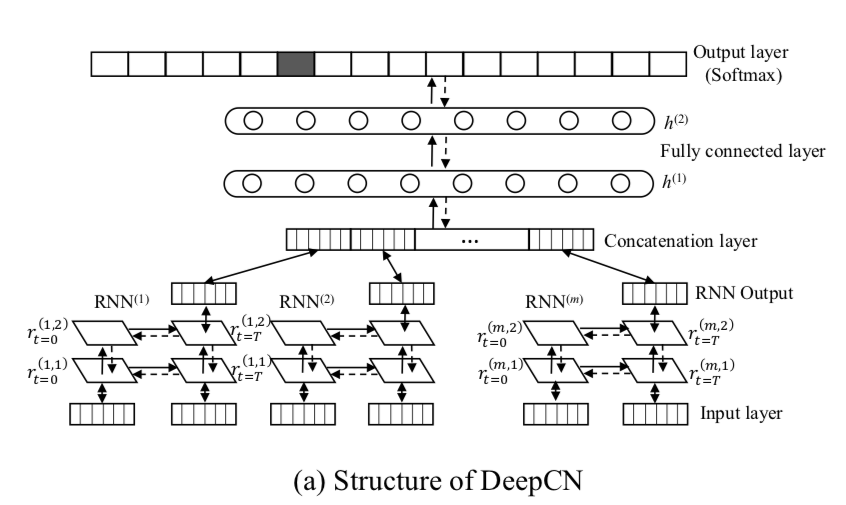

In [14]:
Image("/Users/tpalczew/Desktop/DeepCN.png")

- DCN-1R = 1RNN + 2 Fully connected layers + Softmax (161 classes in my case)

- DeepCN = 6 RNN (for each feature)  + Concatenation layer + 2 Fully connected layers + Softmax (161 classes in my case)


__There is no precise information about layers' sizes in the paper__

In [15]:
newDF2["y"] = pd.factorize(newDF['y'])[0]

In [16]:
newDF2.head(11)

,x,y
0,"[hornby, catalogue, hornby, hobbies, 3.0, prod...",0
1,"[funkybuys, large, christmas, holiday, express...",0
2,"[classic, toy, train, set, track, carriages, l...",0
3,"[hornby, coach, hawksworth, corridor, hornby, ...",0
4,"[hornby, gauge, gildenlow, salt, steam, locomo...",0
5,"[pcs, model, garden, light, double, heads, lam...",1
6,"[hornby, gauge, bogie, passenger, brake, coach...",0
7,"[hornby, santas, express, train, set, hornby, ...",0
8,"[hornby, gauge, western, express, digital, tra...",0
9,"[learning, curve, chuggington, interactive, ch...",0


In [17]:
unique_labels2 = newDF2['y'].unique()
print(len(unique_labels2))

161


In [18]:
x = newDF2['x'].values
y = newDF2['y'].values

In [19]:
print(x[0])

['hornby', 'catalogue', 'hornby', 'hobbies', 3.0, 'product', 'description', 'hornby', 'catalogue', 'box', 'contains', 'one', 'catalogue', '1', '5']


In [20]:
print(x.shape)

(10000,)


In [21]:
maxlen = max(len(r) for r in x)
print(maxlen)

3438


In [22]:
newx = []
for elem in x:
    newx.append( np.pad(elem, (0, maxlen-len(elem)), 'constant'))
    # same length vectors are required to perform the computation in Keras.

In [23]:
print(len(newx[0]))

3438


In [24]:
print((newx[0]))

['hornby' 'catalogue' 'hornby' ... '0' '0' '0']


In [25]:
print(y[0])

0


3438 that's probably too much to keep, we will have to many zeros in large number of examples
so lets just focus on some arbitrary chosen number of words

In [215]:
newxx = []
for elem in newx:
    newxx.append(list(elem[0:100]))

In [218]:
newxx = np.array(newxx)

In [220]:
print(newxx.shape)

(10000, 100)


In [221]:
print(len(newxx))

10000


In [222]:
tokenizer = Tokenizer()

In [223]:
newxxx = []
for elem in newxx:
    newelem = ' '.join(elem)
    newxxx.append(str(newelem))

In [224]:
print(newxxx[0])

hornby catalogue hornby hobbies 3.0 product description hornby catalogue box contains one catalogue 1 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [240]:
tokenizer.fit_on_texts(newxxx)

In [250]:
sequences = np.array(list(tokenizer.texts_to_sequences(newxxx)))

In [251]:
print(sequences.shape)

(10000,)


In [252]:
newxx = []
for elem in sequences:
    newxx.append(list(elem[0:100]))

In [253]:
newxx = np.array(newxx)

In [254]:
print(newxx.shape)

(10000, 100)


In [255]:
X_train, X_temp, y_train, y_temp = train_test_split (newxx, y, test_size=0.2)
X_test , X_valid, y_test, y_valid = train_test_split (X_temp,y_temp,test_size=0.5)

In [256]:
print(X_train[0])

[  440   485  1874  2557   913  5214    49   190 31072    15     9   440
   485  1874  2557  5214    38     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1]


In [257]:
print(y_train[0])

18


In [258]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [259]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [260]:
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [261]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(8000, 100)
(1000, 100)
(1000, 100)


In [266]:
X_train= np.reshape(X_train,(X_train.shape[0], 100, 1))
X_test= np.reshape(X_test,(X_test.shape[0], 100, 1))
X_valid= np.reshape(X_valid,(X_valid.shape[0], 100, 1))

DCN-1R architecture

In [308]:
model = Sequential()

model.add(GRU(128, input_shape = (100,1), activation='tanh'))

model.add(Dense(128, activation="tanh"))

model.add(Dense(256, activation="tanh"))

model.add(Dense(161, activation="sigmoid"))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

5000


In [309]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.001,
                           patience=3,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint('checkpooint.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

model.fit(np.array(X_train), np.array(y_train), validation_data=(X_test, y_test),
                                epochs=150,
                                batch_size=128,
                                callbacks=[early_stop, checkpoint])

print(model.summary())

Train on 8000 samples, validate on 1000 samples
Epoch 1/150
8000/8000 [==============================] - 13s 2ms/step - loss: 4.0410 - acc: 0.0829 - val_loss: 3.7259 - val_acc: 0.0860

Epoch 00001: val_loss improved from inf to 3.72594, saving model to checkpooint.h5
Epoch 2/150
8000/8000 [==============================] - 12s 1ms/step - loss: 3.7357 - acc: 0.0883 - val_loss: 3.6802 - val_acc: 0.0860

Epoch 00002: val_loss improved from 3.72594 to 3.68019, saving model to checkpooint.h5
Epoch 3/150
8000/8000 [==============================] - 13s 2ms/step - loss: 3.7078 - acc: 0.0820 - val_loss: 3.6635 - val_acc: 0.0830

Epoch 00003: val_loss improved from 3.68019 to 3.66351, saving model to checkpooint.h5
Epoch 4/150
8000/8000 [==============================] - 12s 1ms/step - loss: 3.7008 - acc: 0.0811 - val_loss: 3.6654 - val_acc: 0.0860

Epoch 00004: val_loss did not improve from 3.66351
Epoch 5/150
8000/8000 [==============================] - 12s 1ms/step - loss: 3.6998 - acc: 0.08


Epoch 00038: val_loss improved from 2.13501 to 2.04287, saving model to checkpooint.h5
Epoch 39/150
8000/8000 [==============================] - 12s 1ms/step - loss: 2.0365 - acc: 0.4631 - val_loss: 2.0441 - val_acc: 0.4660

Epoch 00039: val_loss did not improve from 2.04287
Epoch 40/150
8000/8000 [==============================] - 12s 1ms/step - loss: 2.0055 - acc: 0.4759 - val_loss: 2.0169 - val_acc: 0.4760

Epoch 00040: val_loss improved from 2.04287 to 2.01690, saving model to checkpooint.h5
Epoch 41/150
8000/8000 [==============================] - 12s 1ms/step - loss: 1.9574 - acc: 0.4829 - val_loss: 2.0271 - val_acc: 0.4760

Epoch 00041: val_loss did not improve from 2.01690
Epoch 42/150
8000/8000 [==============================] - 12s 1ms/step - loss: 1.9265 - acc: 0.4870 - val_loss: 2.0209 - val_acc: 0.4760

Epoch 00042: val_loss did not improve from 2.01690
Epoch 43/150
8000/8000 [==============================] - 11s 1ms/step - loss: 1.9282 - acc: 0.4814 - val_loss: 1.9728 -

In [314]:
y_pred = model.predict(X_valid)
y_pred = np.array([np.argmax(y, axis=None, out=None) for y in y_pred])

In [315]:
cnf_matrix = confusion_matrix(y_valid, y_pred)
print(cnf_matrix)

[[5 2 0 ... 0 0 0]
 [1 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [316]:
class_names = list((set(y_valid)))

Confusion matrix, without normalization


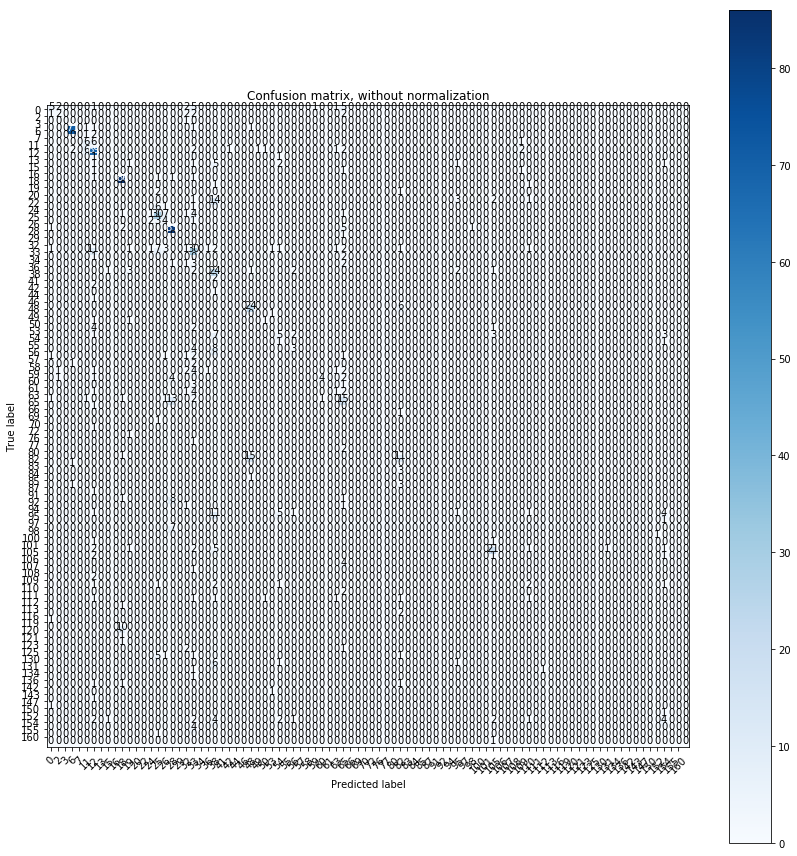

In [317]:
plt.figure(figsize=(12,12))
classifier_name = 'LSTM'
base_dir = '~'
plot_confusion_matrix(cnf_matrix, classes=class_names, classifier_name=classifier_name, save=False,
                          title='Confusion matrix, without normalization')
plt.show()

# DeepCN - DCN-6R

DeepCN = 6 RNN (for each feature) + Concatenation layer + 2 Fully connected layers + Softmax (161 classes in my case)

Now one can do the same thing with x1, x2, ..., x6 features and run the model that is presented below. 
I have limited datset so it's rather useles to lose my time on this task. I hope that the code below gives 
idea about simplem implementation that is possible using keras of similar architecture to DCN-6R

In [ ]:
RNN = recurrent.GRU

x1_le = layers.Input(shape=(100,1), dtype='int32')
x1_le_rnn = RNN(SENT_HIDDEN_SIZE)(x1_l)

x2_le = layers.Input(shape=(100,1), dtype='int32')
x2_le_rnn = RNN(SENT_HIDDEN_SIZE)(x2_le)

x3_le = layers.Input(shape=(100,1), dtype='int32')
x3_le_rnn = RNN(SENT_HIDDEN_SIZE)(x3_le)

x4_le = layers.Input(shape=(100,1), dtype='int32')
x4_le_rnn = RNN(SENT_HIDDEN_SIZE)(x4_le)

x5_le = layers.Input(shape=(100,1), dtype='int32')
x5_le_rnn = RNN(SENT_HIDDEN_SIZE)(x5_le)

x6_le = layers.Input(shape=(100,1), dtype='int32')
x6_le_rnn = RNN(SENT_HIDDEN_SIZE)(x6_le)


merged = layers.concatenate([x1_le_rnn, x2_le_rnn, x3_le_rnn, x4_le_rnn, x5_le_rnn, x6_le_rnn])


dense1 = layers.Dense(128, activation="tanh")(merged)

dense2 = layers.Dense(128, activation="tanh")(dense1)

preds = layers.Dense(161, activation='softmax')(dense2)

model = Model([x1_le, x2_le, x3_le, x4_le, x5_le, x6_le], preds)


#model.fit([x1, x2, x3, x4, x5, x6], y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.05)
